In [1]:
from helpers import *
from distances import *
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax_md import (
    energy
)
# jax.config.update("jax_enable_x64", True)

In [29]:
N = 128
dim = 2
avg_number_density = 0.1

In [30]:
box_size, displacement, shift = init_periodic_box(N=N, dim=dim, avg_num_density=avg_number_density)

In [31]:
def uniform_square(key, N):
    return jr.uniform(key, (N, 2), minval=0.45*box_size, maxval=0.55*box_size)

In [32]:
num_keys = 10
keys = jr.split(jr.PRNGKey(0), num_keys)

In [34]:
all_states = brownian_simulation_vec(keys, 0.5, 0.0001, jnp.arange(1000), N, shift, energy.lennard_jones_pair(displacement, sigma=1, epsilon=1, r_onset=0.9, r_cutoff=2.5), uniform_square)
# all_states = brownian_simulation_vec(keys, 0.001, 0.0001, jnp.arange(1000), N, shift, lambda r: 0., uniform_square)

In [36]:
print(jnp.shape(all_states))
# jnp.save("brownian-lj", all_states[0, :, :, :])

(10, 1002, 128, 2)


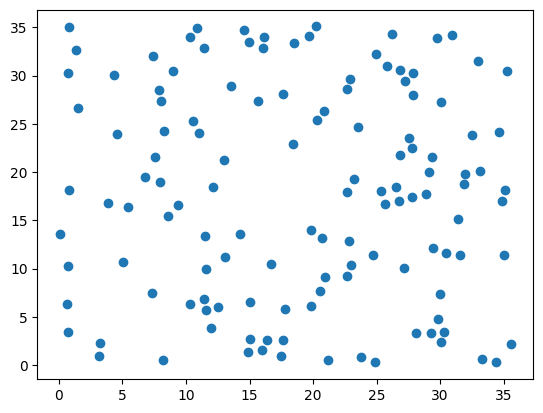

In [37]:
plt.scatter(all_states[0, -1, :, 0], all_states[0, -1, :, 1])
plt.show()

In [38]:
distances = nearest_image_sims_and_times(all_states, box_size)

In [39]:
print(jnp.shape(distances))

(10, 1002, 128, 128)


In [47]:
nbins = 1000
dr = box_size/(nbins)
rr = jnp.arange(dr, box_size+dr, dr)
# rr = rr[:-1]
print(jnp.shape(rr))

(1000,)


In [41]:
rdfs = rdf_pairwise_times_and_sims(distances, dr, nbins)

In [42]:
print(jnp.shape(rdfs))

(10, 1002, 1000)


In [43]:
rdfs_avg = jnp.mean(rdfs, axis=0)

In [44]:
print(jnp.shape(rdfs_avg))

(1002, 1000)


In [48]:
annuli_areas = 2*jnp.pi*rr*dr
normalisation = jnp.roll(annuli_areas, 1)
normalisation = normalisation.at[0].set(jnp.pi*dr*dr)
all_normalisation = jnp.tile(normalisation, (1002, 1))

In [49]:
normalised_rdfs_avg = rdfs_avg/all_normalisation

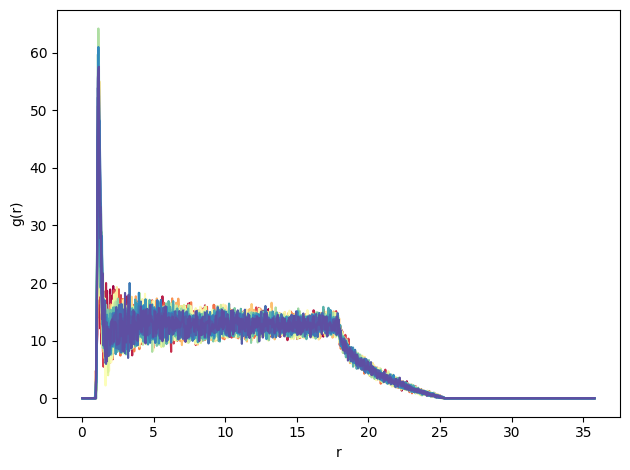

In [50]:
from cycler import cycler
fig, ax = plt.subplots()
custom_cycler = cycler("color", plt.cm.Spectral(jnp.linspace(0, 1, 1000//25)))
ax.set_prop_cycle(custom_cycler)
ks = jnp.arange(5, 1002, 25)
for k in ks:
    #ax.plot(rr, rdfs_avg[k, :])
    ax.plot(rr, normalised_rdfs_avg[k, :])
ax.set_xlabel("r")
ax.set_ylabel("g(r)")
#ax.set_ylim([0, 1000])
plt.tight_layout()
plt.show()